# Assignment 3 Image Segmentation
In this assignment, you will train a dense predictor to conduct semantic segmentation of building components on the QuakeCity dataset developed at SAIL-UH. The dataset consists of synthetic CGI images of earthquake damaged buildings https://sail.cive.uh.edu/quakecity/. The dataset has 8 different classes which can appear in any given image. Your model will predict whether any of the classes is present in each pixel.

In [ ]:
#do not import any aditional packages
import sys
import os
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as F
import time
import torch
import torch.nn as nn
import random
import torch.nn.functional as nnF

Edit the below cell if you are using Colab for this assignment, and to enter the path to the dataset

In [ ]:
from google.colab import drive #comment out this line if you are using Colab
drive.mount('/content/gdrive') #comment out this line if you are using Colab
#############################################################################
# TODO: Edit the path to your assignment folder                             #
#############################################################################
main_path = "/content/gdrive/My Drive/CIVE 6358/Assignment 3"
os.chdir(main_path)
#############################################################################

#do not edit this line
from component2kaggle import component2kagglefn

Mounted at /content/gdrive


The cell below is used to create a Pandas dataframe of image names. Do not edit this cell

In [ ]:
# paths to csv files containing file names for each set of images
train_csv_path = os.path.join(main_path,"split_train.csv")
val_csv_path = os.path.join(main_path,"split_val.csv")
test_csv_path = os.path.join(main_path,"test.csv")

# path to labels and images
data_path = os.path.join(main_path,"dataset")
image_path = os.path.join(data_path,"image")
label_path = os.path.join(data_path,"label")

# define pandas dataframes
train_df = pd.read_csv(train_csv_path,header = None,index_col = None,delimiter=',')
val_df = pd.read_csv(val_csv_path,header = None,index_col = None,delimiter=',')
test_df = pd.read_csv(test_csv_path,header = None,index_col = None,delimiter=',')


If you imported your data correctly, a sample image from the dataset should show after running the cell below together with it's corresponding label

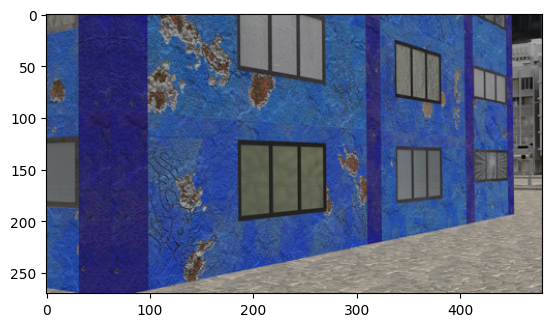

In [ ]:
rand_img_name = train_df.sample().values[0][0]
test_img = Image.open(os.path.join(image_path,rand_img_name))
plt.imshow(test_img)

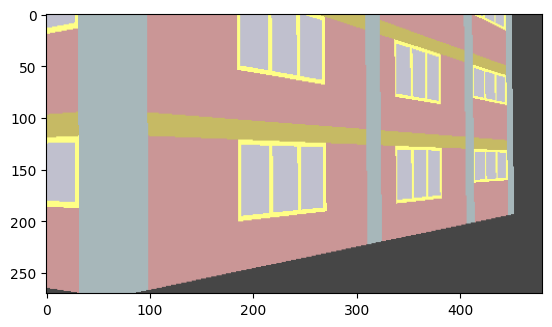

In [ ]:
# load a label image from the train data frame
component_img = Image.open(os.path.join(label_path,rand_img_name))
plt.imshow(component_img)

Each image has 8 possible classes. The classes in the dataset are listed below with the 8 colors assigned provided in parenthesis.

* 0 - wall - (202,150,150) (pink)
* 1 - beam - (198,186,100) (dark yellow)
* 2 - column - (167,183,186) (gray blue)
* 3 - window frame - (255,255,133) (yellow)
* 4 - window pane - (192,192,206) (purple gray blue)
* 5 - balcony - (32,80,160) (blue)
* 6 - slab - (193,134,1) (burnt orange)
* 100 - ignore - (70,70,70) (deep brown)

<br>The Following function is used to one hot encode an array of labels. Remember as this is a dense prediction problem, the output and input have the same size, but the output in this case is a single channel image of size 480x270.  As there are 8 classes, the dimensions of the one hot encoding should be (8x480x270)
* the input of this function is an array containing labels 0,1,2,3,4,5,6,100
* map 0,1,2,3,4,5,6 to channel 0,1,2,3,4,5,6
* map 100 to channel 7

In [ ]:
#one hot encode labels
def label_to_nparray(seg):
    channels = 8
    seg_0 = seg.shape[0]
    seg_1 = seg.shape[1]
    nparray = np.zeros([channels, seg_0, seg_1], dtype=np.uint8)
    for idx in range(0,channels):
        mask = seg == idx
        nparray[idx,:,:] = mask

        if idx == 7:
            idx_ignore = 100
            mask = seg == idx_ignore
            nparray[idx,:,:] = mask

    return nparray

# Part 1:
<br> In the below cell that defines ComponentCustomDataset add 1 or more additional transformations to self.trans
<br> Refer to the following documentation to learn how to add a transformation to self.trans https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html
<br> Look at the following pytorch documentation for transforms: https://pytorch.org/vision/stable/transforms.html#transforms-on-pil-image-and-torch-tensor
<br> Review the following documentation to learn more about Dataset in Pytorch https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset, this class is used to feed images into your neural network

In [ ]:
class ComponentCustomDataset(Dataset):
    def __init__(self, train_df, images_path, labels_path):
        super(ComponentCustomDataset, self).__init__()
        self.csv_path = train_csv_path
        self.image_path = images_path
        self.labels_path = labels_path
        self.train_df = train_df
        #############################################################################
        ## TODO: add 1 or more additional transformations to self.trans             #
        # Refer to sel.rand_trans as an example                                     #
        #############################################################################
        self.trans = transforms.Compose([transforms.ToTensor()])

        ##############################################################################

        self.rand_trans = transforms.Compose([
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            # transforms.ColorJitter(brightness=0.2, hue=0.2),
            ])

    def __getitem__(self, index):
        # x is the input
        # y is the label
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)

        random_img_name = self.train_df.iloc[index].values[0]

        x = Image.open(os.path.join(self.image_path, random_img_name))
        x = self.trans(x)
        x = self.rand_trans(x)

        random.seed(seed)
        torch.manual_seed(seed)
        y = Image.open(os.path.join(self.labels_path, random_img_name))
        y = self.rand_trans(torch.tensor(np.asarray(y)))
        y = label_to_nparray(np.asarray(y))
        y = torch.tensor(y)

        return x, y

    def __len__(self):
        return self.train_df.shape[0]

The below cell creates a object of type ComponentCustomDataset that can be used to get sample images and lables by creating an new object of type DataLoader called train_dataloader
<br> documentation about dataloaders can be found here: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [ ]:
train_dataset = ComponentCustomDataset(train_df,image_path,label_path)
train_dataloader = DataLoader(train_dataset,batch_size=3,shuffle=True)
train_iter = iter(train_dataloader)
x,y = next(train_iter)

A sample from the dataloader is taken here, x is a batch of images that would be fed into your neural network during training, y is the corresponding labels
<br> The shape of x and y are printed below
<br> Note the dimensions are as follows (batch size, channels, rows, columns)

In [ ]:
print(x.shape)
print(y.shape)

torch.Size([3, 3, 270, 480])
torch.Size([3, 8, 270, 480])


The following two cells take a single image from the batch of images from the dataloader
<br> The first cell is of the input image and second is the one hot encoded labels, note the 8 images for the one hot encoded label
<br> The transformations you have applied should be visible, the cell can be ran multiple times to see additional images

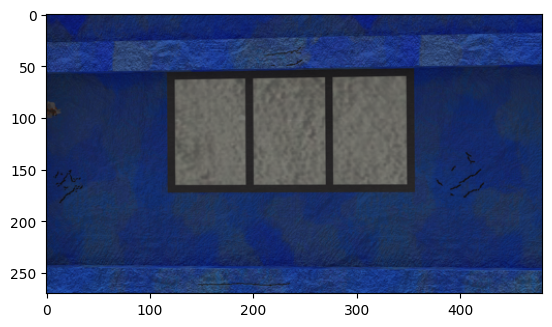

In [ ]:
x,y = next(train_iter)
sample_x = x[0].numpy()
sample_x = np.moveaxis(sample_x,0,-1)
plt.imshow(sample_x)

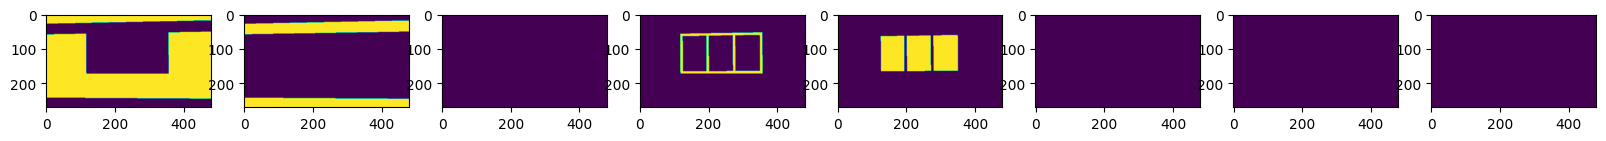

In [ ]:
sample_y=y[0].numpy()
figure, axis = plt.subplots(1,8,figsize=(20,20))
for i in range(8):
  axis[i].imshow(sample_y[i,:,:])

# Part 2:
Edit the below cell to create a CNN for image segmentation. In this assignment, you will create a UNet architecture with resnet connections. The following cell provides starter code, but you must define the forward functions. In particular, your architecture is required employ the following:

* Skip connections similair to ResNet
* Cross Connections from the start of your model to the end like Unet
* Batch normalization layers
* Convolution layers
* Max pooling layers

**The ResNet Bottleneck**

First, we will define what is termed a "Bottleneck". Bottlenecks can also be understood as a design pattern, consisting of three convolution layers, introduced by the ResNet paper (see Figure 5 in the paper) https://arxiv.org/abs/1512.03385. We've provided you with some sample layers to use. You need to complete the init function and write the forward function.
<br>You may make a model completly from scratch without using any of the provided sample layers provided in Bottleneck, but your model must employ all of the mentioned layers and connections.

In [ ]:
# The following class creates one block of the resnet bottleneck block shown in Figure 5 of the ResNet paper
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()

        # self.expansion can be used to scale the last number of channels
        # Note in Figure 5 of the ResNet paper the first 2 conv layers had 64 channels
        # This is followed by 64*4=254 channels
        self.expansion = 4

        # self.ii_downsample is a pair of layers to reduce the number of channels in the identity
        self.ii_downsample = None
        # The convolved input x and identity must be the same dimensions create the skip connection
        # self.ii_downsample is used to reduce the number of channels of the identity
        if in_channels != out_channels:
            self.ii_downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels*self.expansion,
                          kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels*self.expansion))

        # first convolution and batch norm layer
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        #############################################################################
        ## TODO: Define the rest of your your bottleneck based on Figure 5 from the #
        ## ResNet paper. You need two more pairs of conv and batchnorm layers       #
        #############################################################################
        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(
            out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = self.ii_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        #############################################################################
        ## TODO: Edit the forward function to develop the model for your bottleneck #
        #############################################################################
        if self.i_downsample:
            identity = self.i_downsample(identity)

        layers = nn.Sequential(
            self.conv1,
            self.batch_norm1,
            self.relu,
            self.conv2,
            self.batch_norm2,
            self.relu,
            self.conv3,
            self.batch_norm3
        )

        x = torch.add(identity, layers(x))
        x = self.relu(x)
        return x

**UNetResNet**

Now, we will define our custom UNetResNet network. We will use the Bottleneck layer we just defined to create the encoder. We will use transposed convolutions (nn.ConvTranspose2d) for the decoder. Additionally, we will build skip connections from the encoder to the decoder (represented by the gray arrow in Fig 1. in the UNet paper https://arxiv.org/pdf/1505.04597.pdf. Feel free to change the size of the layers provided in the encoder and decoder. For the forward function, you may use the $nnF.interpolate$ function to get your encoder and decoder feature maps to be the same size so you can concatenate them.
<br>You may make a model completly from scratch without using any of the provided sample layers provided in UNetResNet, but your model must employ all of the mentioned layers and connections.

In [ ]:
class UNetResnet(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(UNetResnet, self).__init__()

        self.initial_layer = nn.Conv2d(
            in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # encoder
        self.layer1 = Bottleneck(64, 2, stride=1)
        self.layer2 = Bottleneck(2*4, 2*8, stride=2)
        self.layer3 = Bottleneck(2*8*4, 2*8*4*2, stride=2)
        self.layer4 = Bottleneck(512, 2048, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # decoder
        self.conv1 = Bottleneck(8192, 544, stride=1)
        self.upconv1 = nn.ConvTranspose2d(2176, 1152, 4, 2, 1, bias=False)

        self.conv2 = Bottleneck(1664, 32, stride=1)
        self.upconv2 = nn.ConvTranspose2d(128, 96, 4, 2, 1, bias=False)

        self.conv3 = Bottleneck(160, 24, stride=1)
        self.upconv3 = nn.ConvTranspose2d(96, 64, 4, 2, 1, bias=False)

        self.conv4 = Bottleneck(72, 16, stride=1)
        self.upconv4 = nn.ConvTranspose2d(64, 48, 4, 2, 1, bias=False)

        self.conv5 = Bottleneck(48, 12, stride=1)
        self.upconv5 = nn.ConvTranspose2d(48, 32, 4, 2, 1, bias=False)

        self.conv6 = Bottleneck(32, 8, stride=1)
        self.conv7 = nn.Conv2d(32, num_classes, kernel_size=1, stride=1)

    def forward(self, x):
        #############################################################################
        # TODO: Edit the forward function to develop the model for your UNetResNet  #
        #############################################################################

        x = self.initial_layer(x)
        encode1 = self.layer1(x)
        encode2 = self.layer2(encode1)
        encode3 = self.layer3(encode2)
        encode4 = self.layer4(encode3)

        encode4 = self.conv1(encode4)
        upConv1 = self.upconv1(encode4)

        size1 = (encode3.shape[2], encode3.shape[3])
        decode1 = torch.cat([nnF.interpolate(upConv1, size=size1), encode3], 1)

        decode1 = self.conv2(decode1)
        upConv2 = self.upconv2(decode1)
        size2 = (encode2.shape[2], encode2.shape[3])
        decode2 = torch.cat([nnF.interpolate(upConv2, size=size2), encode2], 1)

        decode2 = self.conv3(decode2)
        upConv3 = self.upconv3(decode2)
        size3 = (encode1.shape[2], encode1.shape[3])
        decode3 = torch.cat([nnF.interpolate(upConv3, size=size3), encode1], 1)

        decode3 = self.conv4(decode3)
        upConv4 = self.upconv4(decode3)

        decode4 = self.conv5(upConv4)
        upConv5 = self.upconv5(decode4)

        decode6 = self.conv6(upConv5)
        decode7 = self.conv7(decode6)
        x = self.pool(decode7)

        return x

The following cell creates the model you have defined and places it into the GPU if it is available
<br>Note a GPU is needed for this assignment to train in a reasonable amount of time

In [ ]:
model = UNetResnet(num_classes = 8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
test_out = model(x.to(device))

# Part 3:
<br>Create the cross entropy loss function for image segmentation. The input into this function will be the predicted labels, which will not be one hot encoded, and the raw response from your network. Calculate the Cross entropy using the given inputs.


In [ ]:
#############################################################################
# TODO: Implement cross entropy loss function for image segmentation in the #
# CEL function below                                                        #
#############################################################################
def CEL(pred, ground):
  summed_CEL = nnF.cross_entropy(pred, ground)
  return summed_CEL

The following function uses the loss function you have written to train your model for one epoch

In [ ]:
def train_loop(dataloader, model, optimizer):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    size = len(dataloader.dataset)
    avg_loss = 0
    iteration = 0
    img_count = 0
    for batch, (x, y) in enumerate(dataloader):
    # Compute prediction and loss

      out = model(x.to(device))

      loss = CEL(out,y.to(device).argmax(dim=1))

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      img_count += x.shape[0]
      if iteration % 5 == 0:
          loss, current = loss.item(),img_count
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
      avg_loss += loss
      iteration += 1
    return avg_loss/iteration

# Part 4:
<br>Edit the following function where indicated to calculate the Intersection Over Union (IOU) given an array of 1's and 0's for the label and predicted values
<br>The array's will be of shape 270x480

In [ ]:
@torch.no_grad()
def manual_iou(dataloader, model):
  total_miou = 0
  iou_idx = 0
  for batch, (x,y) in enumerate(dataloader):

    #prediction from model
    preds=model(x.to(device))

    #convert labels and prediction to array of labels
    pred_labels = preds.argmax(dim=1)
    true_labels = y.argmax(dim=1)
    #calculates IOU for each label in a class that is present
    for image in range(y.shape[0]):
      image_label = (true_labels[image]).cpu().numpy()
      image_prediction = (pred_labels[image]).cpu().numpy()

      for i in range(8):
        outputs = image_prediction == i
        labels = image_label == i

#############################################################################
# TODO: Calculate intersection and union                                    #
# Set the intersection variable and the union variable only                 #
# Use the outputs and labels variables defined in lines 21 and 22           #
#############################################################################
        intersection = np.logical_and(outputs, labels).sum()
        union = np.logical_or(outputs, labels).sum()
#############################################################################

        #only calculate if labels are present
        if np.sum(union) > 0:
          if np.sum(labels) > 0:
            total_miou += (np.sum(intersection) / np.sum(union))
            #count number of ious calculated
            iou_idx += 1


  return total_miou/iou_idx

# Part 5:
<br>The following cell will train your model. Edit the following cell to adjust the hyperparameters of your trained model. Depending on your model, GPU, and hyperparameters expect 3 hours of training time. Expect a difference in your validation mean IOU score and the IOU score on kaggle. These scores may differ unless it is above 0.8 and you correctly implement the IOU function

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

#############################################################################
# TODO: Tune the hyperparameters used to train your model                   #
#############################################################################
#############################################################################
#Only edit the following hyperparameter:
epochs=10
batch_size=3
learning_rate=0.0006
##############################################################################

best_val=1
epoch_list=[]
train_loss_list=[]
val_loss_list=[]
best_epoch=0
best_iou=0
best_iou_epoch=0
iou_list=[]

best_model_path="random"

#optimizer
optimizer = torch.optim.Adam(params=model.parameters(),lr=learning_rate)
lr_scheduler = ExponentialLR(optimizer, gamma=0.9) # 0.99? 0.9? 0.8?

train_df=pd.read_csv(train_csv_path,header=None,index_col=None,delimiter=',')
val_df=pd.read_csv(val_csv_path,header=None,index_col=None,delimiter=',')
test_df=pd.read_csv(test_csv_path,header=None,index_col=None,delimiter=',')

train_comp_dataset = ComponentCustomDataset(train_df,image_path,label_path)
train_comp_dataloader = DataLoader(train_comp_dataset,batch_size=batch_size,shuffle=True)

val_comp_dataset = ComponentCustomDataset(val_df,image_path,label_path)
val_comp_dataloader = DataLoader(val_comp_dataset,batch_size=batch_size,shuffle=True)


for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_list.append(t)

    train_loss=train_loop(train_comp_dataloader,model, optimizer)
    train_loss_list.append(train_loss)
    lr_scheduler.step()

    temp_iou=manual_iou(val_comp_dataloader,model)
    print(f"Validation mIOU is: {temp_iou}")

    iou_list.append(temp_iou)
    if temp_iou>best_iou:
        print(f'new best iou: {temp_iou}')
        best_iou=temp_iou

        best_model_path=os.path.join(main_path,"best_validation_model.pth")
        torch.save(model.state_dict(), best_model_path)


print("Done!")
print("loading best saved model")
model.load_state_dict(torch.load(best_model_path))

Epoch 1
-------------------------------
loss: 2.196824  [    3/ 2130]
loss: 1.935013  [   18/ 2130]
loss: 1.631101  [   33/ 2130]
loss: 1.618946  [   48/ 2130]
loss: 1.698616  [   63/ 2130]
loss: 1.569931  [   78/ 2130]
loss: 1.792371  [   93/ 2130]
loss: 1.625651  [  108/ 2130]
loss: 1.692377  [  123/ 2130]
loss: 1.416725  [  138/ 2130]
loss: 1.445035  [  153/ 2130]
loss: 1.444455  [  168/ 2130]
loss: 1.435975  [  183/ 2130]
loss: 1.195536  [  198/ 2130]
loss: 1.298047  [  213/ 2130]
loss: 1.318787  [  228/ 2130]
loss: 1.377269  [  243/ 2130]
loss: 1.426688  [  258/ 2130]
loss: 1.441214  [  273/ 2130]
loss: 1.809630  [  288/ 2130]
loss: 1.388479  [  303/ 2130]
loss: 1.429882  [  318/ 2130]
loss: 1.639789  [  333/ 2130]
loss: 1.166909  [  348/ 2130]
loss: 1.279560  [  363/ 2130]
loss: 1.214995  [  378/ 2130]
loss: 1.630465  [  393/ 2130]
loss: 1.190925  [  408/ 2130]
loss: 1.286858  [  423/ 2130]
loss: 1.316767  [  438/ 2130]
loss: 1.878521  [  453/ 2130]
loss: 1.456901  [  468/ 2130]


<All keys matched successfully>

The following cells will plot training loss vs Epoch and mean IOU vs Epoch

Text(0, 0.5, 'Average Epoch Training Loss')

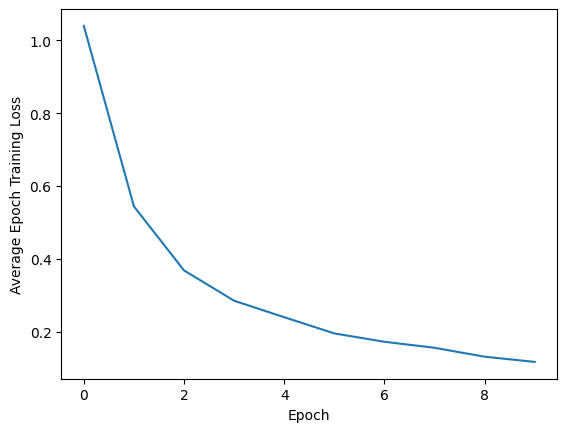

In [ ]:
for i in range(len(train_loss_list)):
    train_loss_list[i]=train_loss_list[i].detach().cpu()
plt.plot(epoch_list,train_loss_list)
plt.xlabel("Epoch")
plt.ylabel("Average Epoch Training Loss")

Text(0, 0.5, 'Validation IOU')

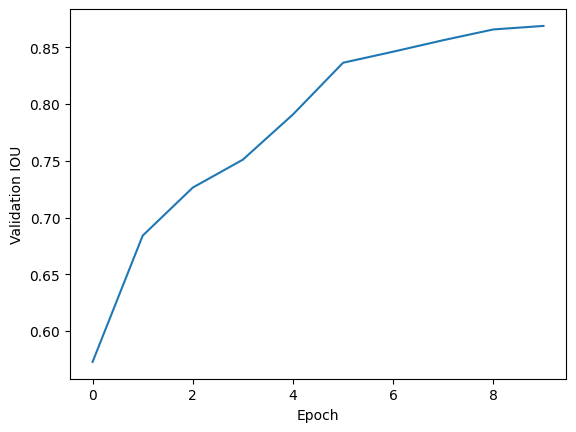

In [ ]:
plt.plot(epoch_list,iou_list)
plt.xlabel("Epoch")
plt.ylabel("Validation IOU")

# Submission Instructions:
<br>Run the following cells to generate the Testing Labels used for your submission on Kaggle
<br>Do NOT edit any of the below cells
<br>You can view the generated images from your moddel in the test_component folder
<br>Use the excel file in the kaggle folder to submit on kaggle

In [ ]:
class TestComponentCustomDataset(Dataset):
    def __init__(self, train_df,images_path):
        super(TestComponentCustomDataset, self).__init__()
        self.csv_path = train_csv_path
        self.image_path = images_path
        self.train_df = train_df
        self.trans= transforms.Compose([transforms.ToTensor()])


    def __getitem__(self, index):
        #x is the input
        #y is the label

        random_img_name=self.train_df.iloc[index].values[0]

        x = Image.open(os.path.join(self.image_path,random_img_name))
        x = self.trans(x)

        return x,random_img_name

    def __len__(self):
        return self.train_df.shape[0]

test_df=pd.read_csv(test_csv_path,header=None,index_col=None,delimiter=',')
test_comp_dataset = TestComponentCustomDataset(test_df,image_path)
test_comp_dataloader = DataLoader(test_comp_dataset,batch_size=1,shuffle=False)

imgPal = Image.open(os.path.join(label_path,"A10001.png"))
pal = imgPal.getpalette()

In [ ]:
model.eval()
for batch,(x,img_name) in enumerate(test_comp_dataloader):
    print(img_name[0])
    y=model(x.to(device))
    preds=y[0]
    torch_hot_y=torch.argmax(preds,dim=0,keepdim=False)
    output = torch_hot_y.cpu().numpy().astype('uint8')
    output = np.where(output == 7, 100, output)
    output = Image.fromarray(output)
    output = output.convert('P')
    output.putpalette(pal)
    output.save(os.path.join(main_path,"test_component_2",img_name[0]))
component2kagglefn(test_csv_path,os.path.join(main_path,"test_component_2"))

A20400.png
A20401.png
A20402.png
A20403.png
A20404.png
A20405.png
A20406.png
A20407.png
A20408.png
A20409.png
A20410.png
A20411.png
A20412.png
A20413.png
A20414.png
A20415.png
A20416.png
A20417.png
A20418.png
A20419.png
A20420.png
A20421.png
A20422.png
A20423.png
A20424.png
A20425.png
A20426.png
A20427.png
A20428.png
A20429.png
A20430.png
A20431.png
A20432.png
A20433.png
A20434.png
A20435.png
A20436.png
A20437.png
A20438.png
A20439.png
A20440.png
A20441.png
A20442.png
A20443.png
A20444.png
A20445.png
A20446.png
A20447.png
A20448.png
A20449.png
A20450.png
A20451.png
A20452.png
A20453.png
A20454.png
A20455.png
A20456.png
A20457.png
A20458.png
A20459.png
A20460.png
A20461.png
A20462.png
A20463.png
A20464.png
A20465.png
A20466.png
A20467.png
A20468.png
A20469.png
A20470.png
A20471.png
A20472.png
A20473.png
A20474.png
A20475.png
A20476.png
A20477.png
A20478.png
A20479.png
A20480.png
A20481.png
A20482.png
A20483.png
A20484.png
A20485.png
A20486.png
A20487.png
A20488.png
A20489.png
A20490.png

In [ ]:
model_params = sum(param.numel() for param in model.parameters())
trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)

print(f'model_params:{model_params}, trainable_params:{trainable_params}')

model_params:127050288, trainable_params:127050288
